# Wasserstein distances
7th March 2024

In [30]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from scipy.special import inv_boxcox
from scipy.stats import boxcox

import gpflow
import gpflow as gpf
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/guepard_repo/')
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code')
sys.path.append(
    '/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/')
import guepard
from load import aphrodite
import glob
import pandas as pd

#import bcm4rcm.updated_bcm as bcm
import matplotlib.ticker as mticker

In [5]:
import tqdm
import tensorflow as tf

In [50]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# remove settingwithcopywarning
pd.options.mode.chained_assignment = None

## For one location

In [ ]:
rcm_list = []
rcm_arr_list = []
#rcm_arr_list_1m = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical*.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df[(df['lon'] == 75.25) & (df['lat'] == 36.25)]
    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    
    p95 = np.percentile(loc_df['tp'], 95)
    loc_df['tp_scale'] = loc_df['tp']/p95

    rcm_arr_list.append(loc_df[['month', 'lon', 'lat', 'tp_scale']].values)
    rcm_list.append(loc_df[['time', 'month', 'lon', 'lat', 'tp']])

NameError: name 'glob' is not defined

In [ ]:
def wass_distance(P_mu, P_var, Q_mu, Q_var):
    """ The 2-Wassertein distance between two normal distributions """
    wass =  (P_mu - Q_mu)**2 + (P_var - Q_var)**2
    return wass

In [ ]:
rcm_stack = np.stack(rcm_arr_list, axis=0)

In [ ]:
in_list= []
in_arr_raw = rcm_stack[:, :, 0].reshape(5, -1, 1)
input_scaler = StandardScaler()
input_scaler.fit(in_arr_raw.reshape(-1, 1))
for i in range(len(rcm_stack)):
    in_arrs = input_scaler.transform(in_arr_raw[i])
    in_list.append(in_arrs)
in_arr = np.array(in_list)
print(in_arr.shape)

(5, 360, 1)


In [ ]:
aphro_ds = aphrodite.collect_APHRO((36.25, 75.25), minyear='1976', maxyear='2005')
aphro_df = aphro_ds.to_dataframe().reset_index()
aphro_df['time'] = pd.to_datetime(aphro_df['time'])
aphro_df['month'] = aphro_df['time'].dt.month
p95 = np.percentile(aphro_df['tp'], 95)
aphro_df['tp_scale'] = aphro_df['tp']/p95

In [ ]:
aphro_df['tp_tr'], lmbd = boxcox(aphro_df['tp_scale'].values.reshape(-1)+0.001)
output_scaler = StandardScaler()
output_scaler.fit(aphro_df['tp_tr'].values.reshape(-1, 1))
aphro_arr = output_scaler.transform(aphro_df['tp_tr'].values.reshape(-1, 1))

In [ ]:
aphro_in_arr= input_scaler.transform(aphro_df['month'].values.astype(np.float64).reshape(-1,1))
aphro_out_arr = aphro_df['tp_tr'].values.astype(np.float64).reshape(-1, 1)

In [ ]:
out_arr_tr = boxcox(rcm_stack[:, :, 3].reshape(-1)+0.001, lmbd)
out_arr_flat = output_scaler.transform(out_arr_tr.reshape(-1, 1))
out_arr = out_arr_flat.reshape(rcm_stack.shape[0], rcm_stack.shape[1], 1,)
print(out_arr.shape)

(5, 360, 1)


In [ ]:
wass_list = []

for i in range(len(rcm_arr_list)):
    rcm_betas = []
    for m in range(12):
        P_var = np.var(out_arr[i, m::12])
        P_mu = np.mean(out_arr[i, m::12])
        Q_var = np.var(aphro_out_arr[m::12])
        Q_mu = np.mean(aphro_out_arr[m::12])
        wass = wass_distance(P_mu, P_var, Q_mu, Q_var)
        rcm_betas.append(wass)
    wass_list.append(rcm_betas)

In [ ]:
wass

5.961571161707374

In [ ]:
wass = np.array(wass_list)
#betas = np.max(wass)-wass

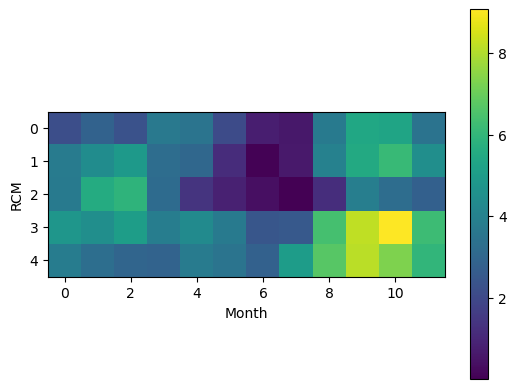

In [ ]:
plt.imshow(wass, cmap='viridis')
plt.xlabel('Month')
plt.ylabel('RCM')
plt.colorbar()

In [ ]:
means = []
vars = []

for i in range(5):
    kernel = gpflow.kernels.RBF(variance=np.var(wass))
    noise_var = 0.01
    rcm1_beta_model = gpflow.models.GPR((np.arange(12).astype(np.float64).reshape(-1,1), wass[i,:].reshape(-1,1)), kernel, noise_variance=noise_var)

    #opt = gpflow.optimizers.Scipy()
    #opt_logs = opt.minimize(rcm1_beta_model.training_loss, rcm1_beta_model.trainable_variables, options=dict(maxiter=100))

    preds = rcm1_beta_model.predict_y(np.linspace(0, 11, 60).astype(np.float64).reshape(-1,1))
    mean_beta = preds[0].numpy().flatten()
    var_beta = preds[1].numpy().flatten()
    means.append(mean_beta)
    vars.append(var_beta)

means = np.array(means)
vars = np.array(vars)   

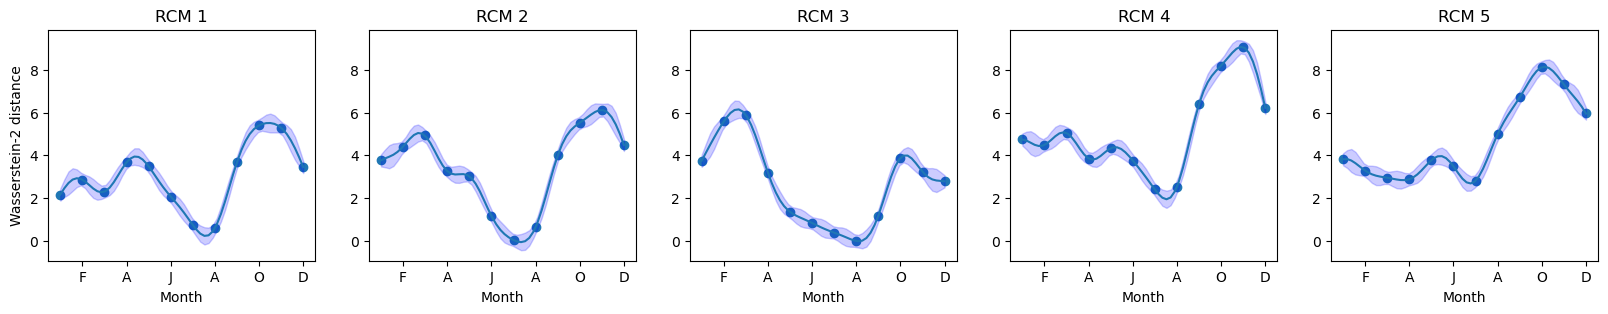

In [ ]:
fig, ax = plt.subplots( 1, 5, figsize=(20, 3), sharey=True)
ax[0].set_ylabel('Wasserstein-2 distance')

for i in range(5):
    ax[i].scatter(np.arange(12), wass[i,:])
    ax[i].plot(np.linspace(0, 11, 60), means[i])
    ax[i].fill_between(np.linspace(0, 11, 60), means[i]-2*np.sqrt(vars[i]), means[i]+2*np.sqrt(vars[i]), alpha=0.2, color='b')
    ax[i].set_xlabel('Month')
    ax[i].set_xticks(np.arange(1, 12, 2), ['F', 'A', 'J', 'A', 'O', 'D'])
    ax[i].yaxis.set_tick_params(labelleft=True)
    ax[i].set_title('RCM {}'.format(i+1))

In [ ]:
means_small = means[1:4]
vars_small = vars[1:4]
wass_small = wass[1:4]

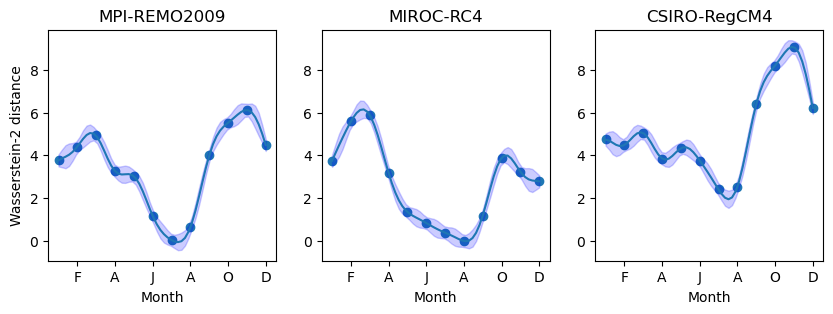

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True)
ax[0].set_ylabel('Wasserstein-2 distance')

rcm_names = ['MPI-REMO2009', 'MIROC-RC4', 'CSIRO-RegCM4']

for i in range(3):
    ax[i].scatter(np.arange(12), wass_small[i])
    ax[i].plot(np.linspace(0, 11, 60), means_small[i])
    ax[i].fill_between(np.linspace(0, 11, 60), means_small[i]-2*np.sqrt(vars_small[i]), means_small[i]+2*np.sqrt(vars_small[i]), alpha=0.2, color='b')
    ax[i].set_xlabel('Month')
    ax[i].set_xticks(np.arange(1, 12, 2), ['F', 'A', 'J', 'A', 'O', 'D'])
    ax[i].yaxis.set_tick_params(labelleft=True)
    ax[i].set_title(rcm_names[i])

plt.savefig('beta_timeseries.pdf', bbox_inches='tight')

## Multiple locations

In [16]:
rcm_list = []

for file in glob.glob('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical*2006.csv'):
    print(file)
    df = pd.read_csv(file, index_col=0)
    loc_df =  df #[(df['lon'] > 60) & (df['lat'] > 25) & (df['lon'] < 105) & (df['lat'] < 40)]
    loc_df['time'] = pd.to_datetime(loc_df['time'])
    loc_df['month'] = loc_df['time'].dt.month
    loc_df = loc_df.sort_values(by=['month', 'lon', 'lat'])
    
    p95 = np.percentile(loc_df['tp'], 95)
    loc_df['tp_scale'] = loc_df['tp']/p95

    rcm_list.append(loc_df[['month', 'lon', 'lat', 'tp_scale']])

/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI-REMO2009_1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_CSIRO_1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MPI_IITM_1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_NOAA_SMHI1976_2006.csv
/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/processed/historical_MIROC_1976_2006.csv


In [19]:
rcm_stack = np.array(rcm_list)
rcm_stack


array([[[1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 1.24560794e-02],
        [1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 2.75448139e-03],
        [1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 2.39949696e-03],
        ...,
        [1.20000000e+01, 1.04750000e+02, 3.97500000e+01, 1.35133287e-03],
        [1.20000000e+01, 1.04750000e+02, 3.97500000e+01, 2.69796991e-04],
        [1.20000000e+01, 1.04750000e+02, 3.97500000e+01, 5.52057955e-06]],

       [[1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 6.53357268e-02],
        [1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 1.98190591e-02],
        [1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 2.45530838e-02],
        ...,
        [1.20000000e+01, 1.04750000e+02, 3.97500000e+01, 5.71988746e-02],
        [1.20000000e+01, 1.04750000e+02, 3.97500000e+01, 8.19546963e-02],
        [1.20000000e+01, 1.04750000e+02, 3.97500000e+01, 6.10236336e-02]],

       [[1.00000000e+00, 6.02500000e+01, 2.02500000e+01, 1.23749444e-01],
        

In [42]:
rcm_arr = rcm_stack.reshape(5, 30, 12, 90, 40, 4)

In [7]:
#rcm_mean_stack = np.stack(rcm_list_means, axis=0)
#rcm_var_stack = np.stack(rcm_list_vars, axis=0)

In [ ]:
#rcm_mean_stack.shape
# RCM experiment x month x lon x lat x year x var

(5, 12, 90, 40, 4)

In [23]:
in_list= []
in_arr_raw = rcm_arr[:, :, :, :, 0:3]
#input_scaler = StandardScaler()
#flat_in_arrs = input_scaler.fit_transform(in_arr_raw.reshape(-1, 3))
in_arrs = in_arr_raw.reshape(rcm_arr.shape[0], rcm_arr.shape[1], rcm_arr.shape[2], rcm_arr.shape[3], 3)  
in_list.append(in_arrs)
in_arr = np.array(in_list)

In [24]:
aphro_ds = aphrodite.collect_APHRO('hma', minyear='1976', maxyear='2005')
ref_ds = loc_df.set_index(['time', 'lat', 'lon']).to_xarray()
aphro_ds1 = aphro_ds.interp_like(ref_ds, 'nearest',)

In [25]:
aphro_ds

<xarray.Dataset>
Dimensions:  (time: 360, lon: 200, lat: 88)
Coordinates:
  * time     (time) datetime64[ns] 1976-01-01 1976-02-01 ... 2005-12-01
  * lon      (lon) float64 60.12 60.38 60.62 60.88 ... 109.1 109.4 109.6 109.9
  * lat      (lat) float64 20.12 20.38 20.62 20.88 ... 41.12 41.38 41.62 41.88
Data variables:
    tp       (time, lat, lon) float32 ...
Attributes:
    plot_legend:  APHRODITE

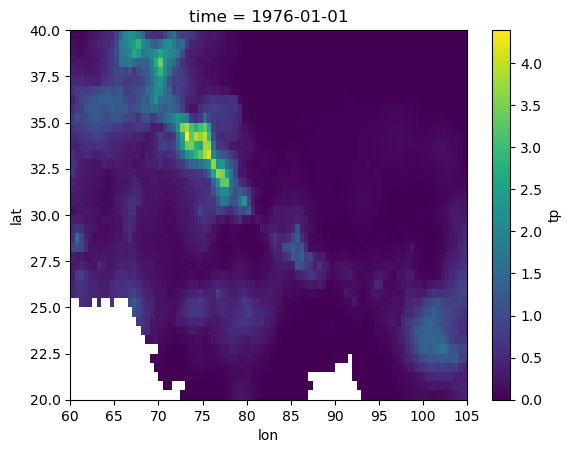

In [ ]:
aphro_ds1.tp.isel(time=0).plot()

In [26]:
aphro_df = aphro_ds1.to_dataframe().reset_index().fillna(0)
aphro_df['time'] = pd.to_datetime(aphro_df['time'])
aphro_df['month'] = aphro_df['time'].dt.month
aphro_df.sort_values(by=['month', 'lon', 'lat'], inplace=True)

p95 = np.percentile(aphro_df['tp'], 95)
aphro_df['tp_scale'] = aphro_df['tp']/p95

#aphro_df_means = aphro_df.groupby(['month', 'lon', 'lat']).mean().reset_index()
#aphro_df_vars = aphro_df.groupby(['month', 'lon', 'lat']).var().reset_index()

In [ ]:
#aphro_df2 = aphro_ds.to_dataframe().reset_index().fillna(0)
#aphro_df2['time'] = pd.to_datetime(aphro_df2['time'])
#aphro_df2['month'] = aphro_df2['time'].dt.month
#aphro_df2.sort_values(by=['time', 'lon', 'lat'], inplace=True)
#aphro_df2 = aphro_df2.groupby(['month', 'lon', 'lat']).mean().reset_index()
#aphro_in_arr2 = input_scaler.transform(aphro_df2[['month', 'lon', 'lat']].values.astype(np.float64))

In [47]:
# output_scaler = StandardScaler()
aphro_arr_out = aphro_df['tp_scale'].values #output_scaler.fit_transform(reshape(-1, 1))
aphro_out_arr = aphro_arr_out.reshape(rcm_arr.shape[1], rcm_arr.shape[2], rcm_arr.shape[3], rcm_arr.shape[4])

In [45]:
#aphro_in_arr = input_scaler.transform(aphro_df[['month', 'lon', 'lat']].values.astype(np.float64))
#aphro_in_arr = aphro_in_arr.reshape(rcm_stack.shape[1], rcm_stack.shape[2], rcm_stack.shape[3], rcm_stack.shape[4],3)
#aphro_out_arr = aphro_df['tp_tr'].values.astype(np.float64).reshape(-1, 1)
print(aphro_out_arr.shape)

(30, 12, 90, 40, 1)


In [ ]:
out_arr_tr = boxcox(rcm_stack[:, :, :, :, :, 3].reshape(-1)+0.001, lmbd)
out_arr_flat = output_scaler.transform(out_arr_tr.reshape(-1, 1))
out_arr = out_arr_flat.reshape(rcm_stack.shape[0], rcm_stack.shape[1], rcm_stack.shape[2], rcm_stack.shape[3], rcm_stack.shape[4])
print(out_arr.shape)

(5, 12, 90, 40, 30, 1)


In [ ]:
wass_dists = []

for i in range(len(rcm_list)):
    rcm_betas = []
    P_var = np.var(out_arr[i], axis=-2)
    P_mu = np.mean(out_arr[i], axis=-2)
    Q_var = np.var(aphro_out_arr, axis=-2)
    Q_mu = np.mean(aphro_out_arr, axis=-2)
    wass = wass_distance(P_mu, P_var, Q_mu, Q_var)
    rcm_betas.append(wass)
    wass_dists.append(wass)

In [ ]:
wass_arr = np.array(wass_dists)
betas = np.max(wass_arr)-wass_arr

In [31]:
from models import moe

In [48]:
print(rcm_arr[:,:,:,:,:,3].shape)
print(aphro_out_arr.shape)

(5, 30, 12, 90, 40)
(30, 12, 90, 40)


In [57]:
def rcm_wass_distances(rcm_arr: np.ndarray, aphro_arr:np.ndarray, save:bool=False)-> np.ndarray:
    """
    Returns 2-Wasserstein distances between RCM and APHRODITE data. 
    The data should have already been scaled by it 95th percentile value.

    Args:
        rcm_list (np.ndarray): scaled RCM data. Shape RCM * years * months * lat * lon (5, 30, 12, 90, 40).
        aphrodite (np.ndarray): scaled APHRODITE data.

    Returns:
        np.ndarray: Wasserstein distances (not normalised). 
    """

    wass_dists = []

    # calculate wass dist using scipy
    # TODO: vectorise this

    for i in range(rcm_arr.shape[0]):
        for m in range(rcm_arr.shape[2]):
            for lon in range(rcm_arr.shape[3]):
                for lat in range(rcm_arr.shape[4]):
                    wass = sp.stats.wasserstein_distance(rcm_arr[i,:, m, lon, lat], aphro_arr[:, m, lon, lat])
                    wass_dists.append(wass)
                    
    wass_arr = np.array(wass_dists)
    wass_arr = wass_arr.reshape(rcm_arr.shape[0], rcm_arr.shape[2], rcm_arr.shape[3], rcm_arr.shape[4])

    if save:
        np.save('wass_dists.npy', wass_arr)
    
    return wass_arr

In [55]:
import scipy as sp

In [58]:
rcm_wass_distances(rcm_arr[:,:,:,:,:,3], aphro_out_arr, save=True)

array([[[[0.28343375, 0.42357482, 0.23883798, ..., 0.07196361,
          0.13745879, 0.11256998],
         [0.10870625, 0.23261775, 0.06711878, ..., 0.17650437,
          0.19422289, 0.12754039],
         [0.19065075, 0.12516402, 0.37120038, ..., 0.08464616,
          0.05395398, 0.14971918],
         ...,
         [0.05523828, 0.02986541, 0.09050604, ..., 0.02593523,
          0.04645112, 0.05335834],
         [0.0370327 , 0.04564597, 0.02090692, ..., 0.05055198,
          0.04162574, 0.03885386],
         [0.0152286 , 0.05218694, 0.02881573, ..., 0.02934068,
          0.02867857, 0.03625668]],

        [[0.23716958, 0.31797989, 0.34246699, ..., 0.08940423,
          0.19688187, 0.20688491],
         [0.16168305, 0.15235465, 0.20007867, ..., 0.10614728,
          0.10228289, 0.11632787],
         [0.08271295, 0.12361463, 0.41259422, ..., 0.0666216 ,
          0.10158876, 0.07424969],
         ...,
         [0.05119306, 0.06193687, 0.07271786, ..., 0.04480352,
          0.03814097, 0.0

In [ ]:
wass_arr = np.save('wass_arr.npy', wass_arr)

## BCMs

In [ ]:
df_bcm_in = pd.DataFrame(aphro_in_arr.reshape(-1,3), columns=['month', 'lon', 'lat'])
df_bcm_in = df_bcm_in.sort_values(by=['month', 'lon', 'lat'])

In [311]:
for i in range(5):
    df_bcm_in['wass'+str(i)] = wass_arr[i].reshape(-1)

<Axes: xlabel='lon', ylabel='lat'>

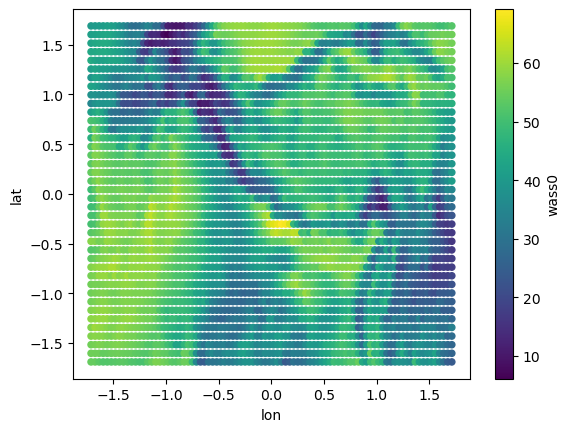

In [312]:
df_bcm_in[df_bcm_in['month']>1.59].plot.scatter(x='lon', y='lat', c='wass0', cmap='viridis')

In [320]:
df_bcm_in.sort_values(by=['month', 'lon', 'lat'], inplace=True)
df_bcm_in['lat_group'] = pd.cut(df_bcm_in['lat'], 10, labels=np.arange(10))
df_bcm_in['lon_group'] = pd.cut(df_bcm_in['lon'], 15, labels=np.arange(15))

In [371]:
df_list = []
gb = df_bcm_in.groupby(['month', 'lat_group',])# 'lon_group'])
df_list.extend([gb.get_group(x)[['month', 'lon', 'lat', 'wass0', 'wass1', 'wass2', 'wass3', 'wass4',]].values for x in gb.groups])

In [372]:
arr = np.array(df_list)
arr.shape

(120, 360, 8)

In [373]:
models = []

# seperate x and y
num_split = 101

# list X of num_split np.arrays
Xl = arr[:, :, 0:3]

wass_scaler = StandardScaler()
x_wass_scaled = wass_scaler.fit_transform(arr[:, :, 3:].reshape(-1, 5))

for i in tqdm.tqdm(range(1)):
    # list of Y num_split np.arrays
    Yl = x_wass_scaled[:, i].reshape(arr.shape[0], arr.shape[1], 1)

    # submodels
    kernel = gpflow.kernels.Matern32(lengthscales=[0.5, 0.1, 0.1], variance=1.0)
    mean = gpflow.mean_functions.Constant(np.mean(arr[:, :, i]))
    noise_var = 0.01
    submodels = guepard.utilities.get_gpr_submodels(zip(Xl, Yl), kernel, mean_function=mean, noise_variance=noise_var)

    # model 
    m_rbcm = guepard.baselines.Ensemble(models=submodels, method=guepard.baselines.EnsembleMethods.RBCM, weighting=guepard.baselines.WeightingMethods.VAR)
    opt = gpflow.optimizers.Scipy()
    opt_logs = opt.minimize(m_rbcm.training_loss, m_rbcm.trainable_variables, options=dict(maxiter=100))
    models.append(m_rbcm)

100%|██████████| 1/1 [00:32<00:00, 32.57s/it]


In [374]:
gpflow.utilities.print_summary(m_rbcm)

╒══════════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════════════╕
│ name                                     │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                     │
╞══════════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════════════╡
│ Ensemble.mean_function.c                 │ Parameter │ Identity         │         │ True        │ ()      │ float64 │ -0.00832                  │
│ Ensemble.models[0].mean_function.c       │           │                  │         │             │         │         │                           │
│ Ensemble.models[1].mean_function.c       │           │                  │         │             │         │         │                           │
│ Ensemble.models[2].mean_function.c       │           │                  │         │             │         │   

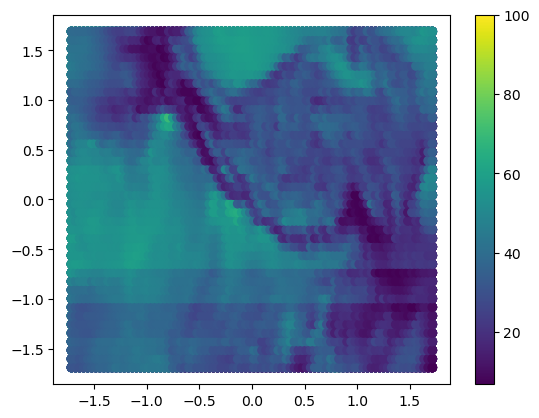

In [379]:
for i in range(120):
    plt.scatter(arr[i, :, 1], arr[i, :, 2], c=arr[i , :, 4], vmax=100)
plt.colorbar()

In [504]:
aphro_in_arr2.shape

(211200, 3)

In [505]:
df_bcm_in2 

,month,lon,lat,lat_group
0,-1.593255,-1.722535,-1.710935,0
7040,-1.593255,-1.722535,-1.710935,0
14080,-1.593255,-1.722535,-1.710935,0
21120,-1.593255,-1.722535,-1.710935,0
28160,-1.593255,-1.722535,-1.710935,0
...,...,...,...,...
183039,1.593255,2.107459,0.801324,7
190079,1.593255,2.107459,0.801324,7
197119,1.593255,2.107459,0.801324,7
204159,1.593255,2.107459,0.801324,7


In [506]:
df_bcm_in2 = pd.DataFrame(aphro_in_arr2, columns=['month', 'lon', 'lat'])
df_bcm_in2 = df_bcm_in2.sort_values(by=['month', 'lon', 'lat'])
df_bcm_in2['lat_group'] = pd.cut(df_bcm_in2['lat'], 11 , labels=np.arange(11))
#df_bcm_in2['lon_group'] = pd.cut(df_bcm_in['lon'], 20, labels=np.arange(20))

In [507]:
df_list3 = []
gb2 = df_bcm_in2.groupby(['month', 'lat_group'])# 'lon_group'])
df_list3.extend([gb2.get_group(x)[['month', 'lon', 'lat']].values for x in gb2.groups])

In [484]:
df_list[-1].shape

(1260, 3)

In [479]:
df_list2[0].shape

(1260, 3)

In [508]:
arr2 = np.array(df_list3)

In [509]:
mean_list = []
var_list = []

#x_wass_plot = wass_scaler.fit_transform(arr2[:, :, 3:].reshape(-1, 5))

for i in tqdm.tqdm(range(1)):
    # predictions
    #m = models[i]
    preds = m_rbcm.predict_y(arr2.reshape(-1, 3))
    mean_beta = preds[0].numpy().flatten()
    var_beta = preds[1].numpy().flatten()
    mean_list.append(mean_beta)
    var_list.append(var_beta)

100%|██████████| 1/1 [05:35<00:00, 335.87s/it]


In [398]:
arr2

array([[[-1.59325501, -1.72253464, -1.71093492],
        [-1.59325501, -1.72253464, -1.66762012],
        [-1.59325501, -1.72253464, -1.62430531],
        ...,
        [ 1.59325501, -1.54931886, -1.49436088],
        [ 1.59325501, -1.54931886, -1.45104607],
        [ 1.59325501, -1.54931886, -1.40773127]],

       [[-1.59325501, -1.53007267, -1.71093492],
        [-1.59325501, -1.53007267, -1.66762012],
        [-1.59325501, -1.53007267, -1.62430531],
        ...,
        [ 1.59325501, -1.35685689, -1.49436088],
        [ 1.59325501, -1.35685689, -1.45104607],
        [ 1.59325501, -1.35685689, -1.40773127]],

       [[-1.59325501, -1.33761069, -1.71093492],
        [-1.59325501, -1.33761069, -1.66762012],
        [-1.59325501, -1.33761069, -1.62430531],
        ...,
        [ 1.59325501, -1.16439492, -1.49436088],
        [ 1.59325501, -1.16439492, -1.45104607],
        [ 1.59325501, -1.16439492, -1.40773127]],

       ...,

       [[-1.59325501,  1.54931886,  1.75424973],
        [-1

In [377]:
means = np.array(mean_list)
variances = np.array(var_list) 

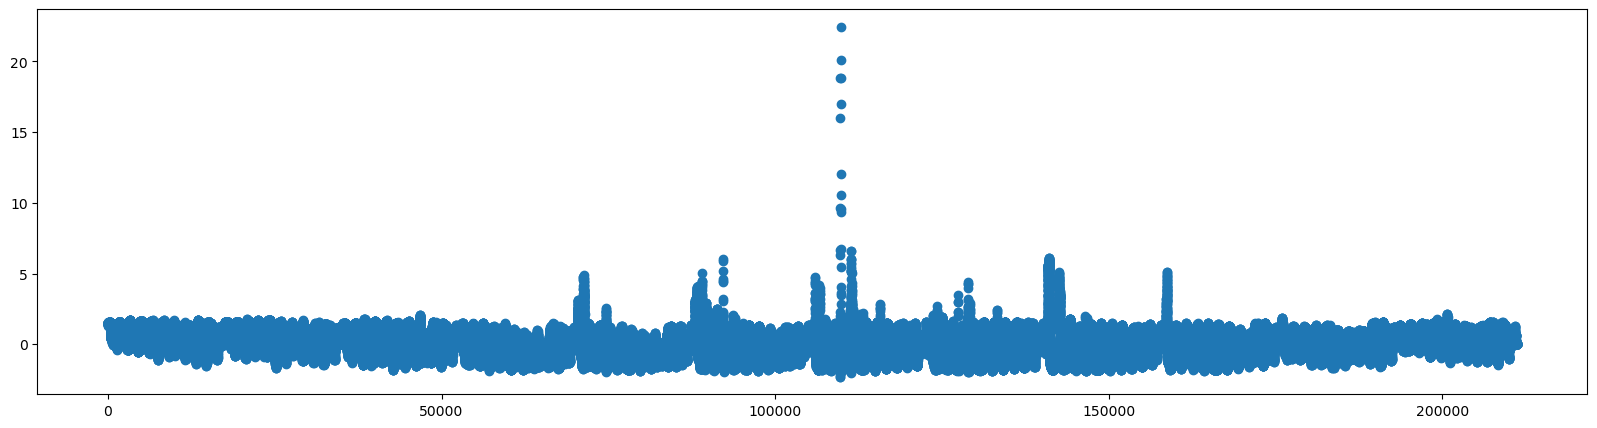

In [510]:
plt.figure(figsize=(20, 5))
plt.scatter(np.arange(len(mean_beta)), mean_beta)

In [512]:
means_raw = wass_scaler.inverse_transform(np.vstack((mean_beta, mean_beta, mean_beta, mean_beta, mean_beta,)).T)

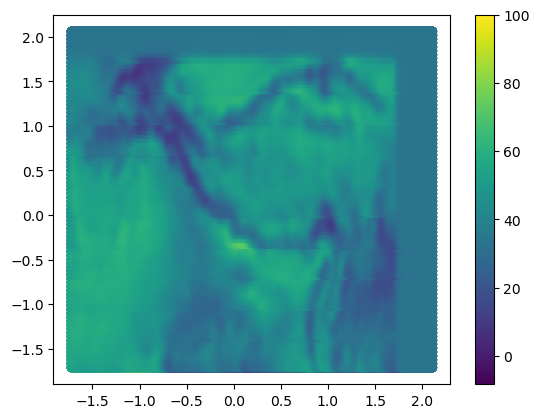

In [514]:
plt.scatter(arr2.reshape(-1, 3)[:, 1], arr2.reshape(-1, 3)[:, 2], c=means_raw[:, 0], vmax=100)
plt.colorbar()

In [9]:
import xarray as xr

In [391]:
raw_inputs = input_scaler.inverse_transform(Xl.reshape(-1, 3))

In [392]:
df = pd.DataFrame({'months':raw_inputs[:,0], 'lons':raw_inputs[:,1], 'lats':raw_inputs[:,2]})
df['rcm1_wass'] = means_raw[:, 0]

In [393]:
raw_inputs.shape

(43200, 3)

In [394]:
ds_plot = df.set_index(['months', 'lons', 'lats']).to_xarray()

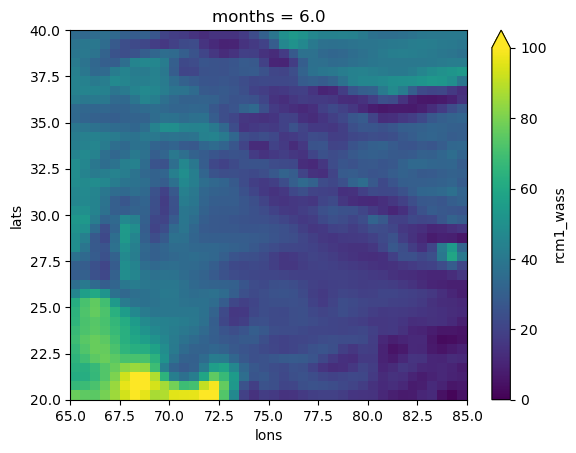

In [395]:
ds_plot.isel(months=5).sel(lats=slice(20,40), lons=slice(65,85)).rcm1_wass.plot(x='lons', y='lats', cmap='viridis',vmin=0, vmax=100)

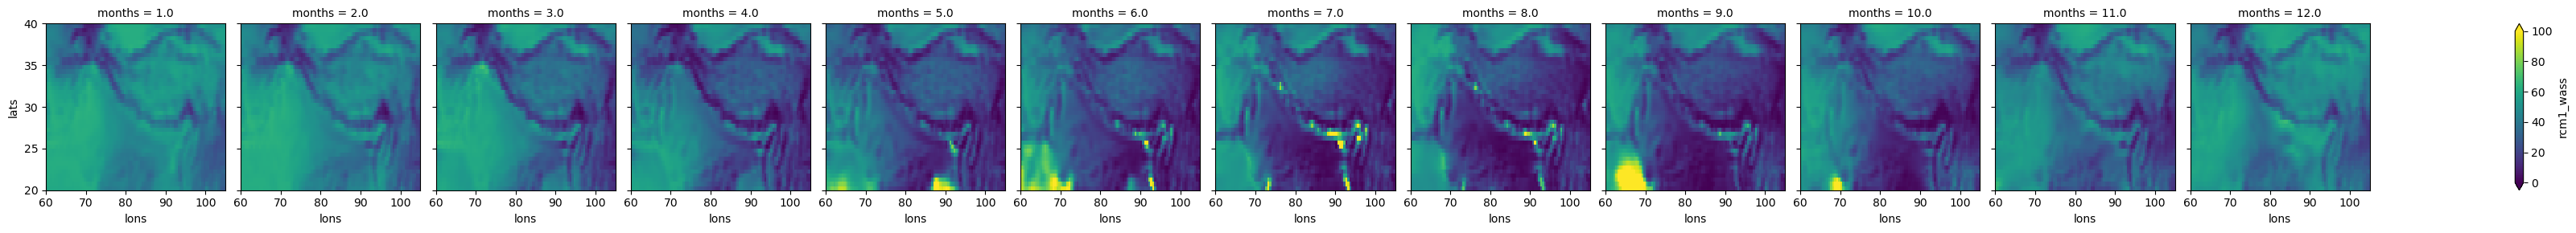

In [397]:
ds_plot.rcm1_wass.plot(x='lons', y='lats', col='months', cmap='viridis', vmax=100, vmin=0)

In [440]:
means_shaped = means.reshape(90, 40, 12)

In [298]:
means_small_shaped = means_shaped[1:4]

In [10]:
proj= ccrs.PlateCarree()
fig, ax = plt.subplots(2, 12, figsize=(20, 6), sharey=True, sharex=True, subplot_kw=dict(projection=proj))

# Map
land_50m = cf.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="darkgrey", facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(1):
    ax[i, 0].set_ylabel('RCM {}'.format(i+1), labelpad=20)
    for m in range(12):
        ax[i,m].add_feature(ocean_50m)
        ax[i,m].set_extent([60.25, 104.25, 20.25, 40])
        im = ax[i, m].imshow(np.swapaxes(means_shaped[m], axis1=0, axis2=1), extent=(60.25, 104.25, 20.25, 40),
                            origin='lower', cmap='viridis', vmin=0)
        
        gl = ax[i,m].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
        gl.top_labels = False
        gl.right_labels = False
        
        if i != 4:
            gl.bottom_labels = False
    
        if m != 0:
            gl.left_labels = False

cbar_ax = fig.add_axes([0.35, -0.05, 0.2, 0.02])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal')

NameError: name 'ccrs' is not defined

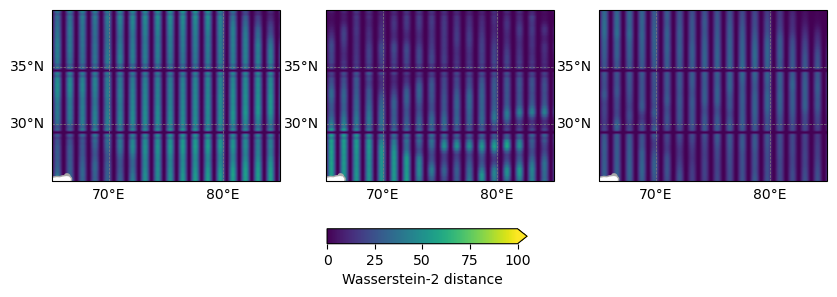

In [300]:
proj= ccrs.PlateCarree()
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=True, subplot_kw=dict(projection=proj))

# Map
land_50m = cf.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="darkgrey", facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(3):
    #ax[i, 0].set_ylabel('RCM {}'.format(i+1), labelpad=20)
    ax[i].add_feature(ocean_50m)
    ax[i].set_extent([65, 85, 25, 40])
    im = ax[i].imshow(np.swapaxes(means_shaped[i+1], axis1=0, axis2=1), extent=(60.25, 104.25, 20.25, 40),
                            origin='lower', cmap='viridis', vmin=0, vmax=100)

    gl = ax[i].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.xlocator = mticker.FixedLocator([70, 80])
    gl.ylocator = mticker.FixedLocator([30, 35])
    gl.top_labels = False
    gl.right_labels = False

cbar_ax = fig.add_axes([0.4, 0, 0.2, 0.05])
fig.colorbar(im, cax=cbar_ax, orientation='horizontal', label='Wasserstein-2 distance', extend='max')
plt.savefig('wass_map_raw.pdf', bbox_inches='tight')

In [8]:
import cartopy.crs as ccrs
import cartopy.feature as cf

In [11]:
wass_arr =  np.load('/Users/kenzatazi/Documents/CDT/Code/bcm4rcm/data/weights/wass_arr.npy')

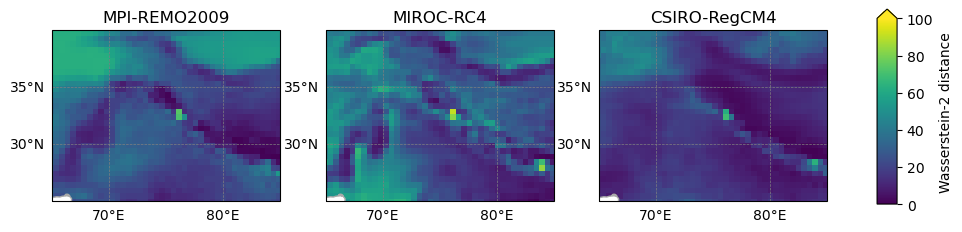

In [13]:
proj= ccrs.PlateCarree()
fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharey=True, sharex=True, subplot_kw=dict(projection=proj))

rcm_names = ['MPI-REMO2009', 'MIROC-RC4', 'CSIRO-RegCM4']

# Map
land_50m = cf.NaturalEarthFeature(
    "physical", "land", "50m", edgecolor="darkgrey", facecolor='whitesmoke',)
ocean_50m = cf.NaturalEarthFeature(
    "physical", "ocean", "50m", edgecolor="darkgrey", facecolor='white')

for i in range(3):
    ax[i].set_title(rcm_names[i])
    ax[i].add_feature(ocean_50m)
    ax[i].set_extent([65, 85, 25, 40])
    im = ax[i].imshow(np.swapaxes(wass_arr[i+1, 6], axis1=0, axis2=1), extent=(60.25, 104.25, 20.25, 40),
                            origin='lower', cmap='viridis', vmin=0, vmax=100)

    gl = ax[i].gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
    gl.xlocator = mticker.FixedLocator([70, 80])
    gl.ylocator = mticker.FixedLocator([30, 35])
    gl.top_labels = False
    gl.right_labels = False

cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.65])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='Wasserstein-2 distance', extend='max')
plt.savefig('wass_map_raw_3cms.pdf', bbox_inches='tight')